In [0]:
#importing libraries
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from statistics import mean 
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

In [0]:
#mounting my drive
from google.colab import drive
drive.mount('/content/drive/')

In [0]:
X1 =  np.load('/content/drive/My Drive/normalized_phase_diff.npy')
X2 = np.load('/content/drive/My Drive/normalized_amplitude_reshaped.npy')
y =  np.load('/content/drive/My Drive/labels.npy')

INPUT_COUNT = X1.shape[1]
X1 = X1 - np.transpose(X1.mean(axis=1).repeat(INPUT_COUNT).reshape(INPUT_COUNT, -1))
X1 = np.absolute(X1)

X2 = X2 - np.transpose(X2.mean(axis=1).repeat(INPUT_COUNT).reshape(INPUT_COUNT, -1))
X2 = np.absolute(X2)

X = np.append(X1, X2, axis=1)

del X1, X2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1999596)

del X, y

X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)



INPUT_COUNT = X_test.shape[1]


In [0]:
#class to instantnize network object
class Net(nn.Module):
    def __init__(self, h_layers, nodes_phl):
        super().__init__()

        self.h_layers = h_layers
        
        self.input = nn.Sequential(
            nn.Linear(INPUT_COUNT, nodes_phl),
            nn.BatchNorm1d(nodes_phl),
            nn.ReLU()
        )
        
        self.hidden = nn.ModuleList()
        for k in range(h_layers-1):
            self.hidden.append(nn.Sequential(
            nn.Linear(nodes_phl, nodes_phl),
            nn.BatchNorm1d(nodes_phl),
            nn.ReLU()
        ))
        
        self.output = nn.Linear(nodes_phl, 1) if h_layers>0 else nn.Linear(INPUT_COUNT, 1)
        
        self.drop_layer = nn.Dropout(p=0.25)
    
    def forward(self, X):#forward propogation through network

        if self.h_layers:
          X = self.input(X)
          X = self.drop_layer(X)
        for layer in self.hidden:
          X = layer(X)
          X = self.drop_layer(X)
        X = self.output(X)
        return torch.sigmoid(X)

In [0]:
# function to calculate metrics for current batch
def calc_metrics(y_pred, y_true):
  epsilon = 1e-7
  '''rounded each element to either 0 for less than 0.5 or 1 for greater than 0.5'''
  y_pred = torch.round(y_pred)

  
  tp = (y_true * y_pred).sum() # true positive
  fp = ((1-y_true) * y_pred).sum() # false positive
  fn = (y_true * (1-y_pred)).sum()# calculating false negative

  precision = tp / (tp + fp + epsilon)
  recall = tp / (tp + fn + epsilon )
  f1 = 2*tp / (2*tp + fp + fn + epsilon)

  return f1, precision, recall


In [0]:
#class to create F1_loss object instance
class F1_Loss(nn.Module):
    
    def __init__(self, epsilon=1e-7):
        super().__init__()
        self.epsilon = epsilon
        
    def forward(self, y_pred, y_true,):
        
        tp = (y_true * y_pred).sum()
        fp = ((1 - y_true) * y_pred).sum()
        fn = (y_true * (1 - y_pred)).sum()


        f1 = 2*tp / (2*tp + fp + fn + self.epsilon)
        return 1 - f1

f1_loss = F1_Loss()

In [0]:
#instantizing loss_function 
loss_function = f1_loss

In [0]:
#function to calculate loss and metrics
def calc_loss_n_metrics(outputs, batch_y):
  outputs = outputs.view(-1)
  loss = loss_function(outputs, batch_y)
  f1, precision, recall = calc_metrics(outputs, batch_y)
  return loss, f1, precision, recall

In [0]:
#function to pass batch through network with some additional arguments
def fwd_pass(net, optimizer, batch_X, batch_y, train):
    
    if train:
      net.train()
      net.zero_grad()
      outputs = net(batch_X)
      loss, f1, precision, recall = calc_loss_n_metrics(outputs, batch_y)
      loss.backward()
      optimizer.step()  
    
    else:
      net.eval()
      with torch.no_grad():
        outputs = net(batch_X)
      loss, f1, precision, recall = calc_loss_n_metrics(outputs, batch_y)
    
    

    return loss, f1, precision, recall

In [0]:
# completing one epoch through the given dataset
def one_epoch(net, optimizer, X, y, BATCH_SIZE, train=False):
  LOSS = []
  F1 = []
  PRECISION = []
  RECALL = []
  for i in range(0, len(X), BATCH_SIZE):
    batch_X = X[i:i+BATCH_SIZE].view(-1, INPUT_COUNT)
    batch_y = y[i:i+BATCH_SIZE].view(-1)
    
    batch_X, batch_y = batch_X.cuda(), batch_y.cuda()

    loss, f1, precision, recall = fwd_pass(net, optimizer, batch_X, batch_y, train)
    LOSS.append(loss)
    F1.append(f1)
    PRECISION.append(precision)
    RECALL.append(recall)
  LOSS = torch.mean(torch.stack(LOSS))
  F1 = torch.mean(torch.stack(F1))
  PRECISION = torch.mean(torch.stack(PRECISION))
  RECALL = torch.mean(torch.stack(RECALL))

  return LOSS, F1, PRECISION, RECALL


In [0]:
nodes_phl_list = np.array([32, 64, 128, 256, 512, 1024, 2048])
METRICS=[]
#function to train the network and save the best model
def train():
    BATCH_SIZE = 32768

    

    for nodes_phl in tqdm(nodes_phl_list):
      #instantizing network
      net = Net(4, nodes_phl).cuda()
      #intializing optimimzer instance
      optimizer = optim.Adam(net.parameters())
      best_val_loss=None
      #instantizing TRAINING and VALIDATION lists to save metrics
      threshold=20
      while(True):
          epoch_training_loss, epoch_training_f1, epoch_training_precision, epoch_training_recall = one_epoch(net, optimizer, X_train, y_train, BATCH_SIZE, True)
          
          print('training_loss: ', epoch_training_loss)    
          print('training_f1: ', epoch_training_f1)
          print('training_precision: ', epoch_training_precision)
          print('training_recall: ', epoch_training_recall)
          
          epoch_val_loss, epoch_val_f1, epoch_val_precision, epoch_val_recall = one_epoch(net, optimizer, X_test, y_test, BATCH_SIZE, False)
          
          print('val_loss: ', epoch_val_loss)
          print('val_f1: ', epoch_val_f1)
          print('val_precision: ', epoch_val_precision)
          print('val_recall: ', epoch_val_recall)

          if not best_val_loss:
            best_val_loss = epoch_val_loss + 1

          is_best = epoch_val_loss < best_val_loss
          best_val_loss = min(epoch_val_loss, best_val_loss)

          if is_best:
            print('BEST VALIDATION LOSS')
            counter=0
            best_loss = epoch_val_loss.item()
            best_f1 = epoch_val_f1.item()
            corr_precision = epoch_val_precision.item()
            corr_recall = epoch_val_recall.item()
            
          counter += 1
          if(counter==threshold):
            METRICS.append([best_loss, best_f1, corr_precision, corr_recall])
            break


In [0]:
#training network
train()

In [0]:
METRICS = np.array(METRICS)
METRICS = np.transpose(METRICS)
torch.save({    
    'metrics': METRICS,
    'nodes_phl': nodes_phl_list
            }, F"/content/drive/My Drive/nodes_phl.pt" )


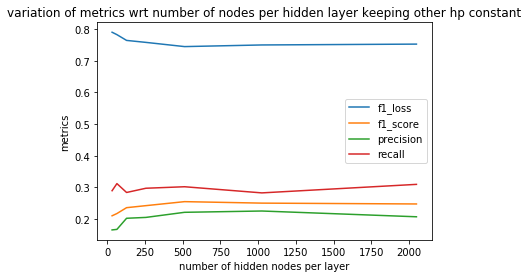

In [0]:
checkpoint = torch.load("/content/drive/My Drive/nodes_phl.pt")
METRICS = checkpoint['metrics']
nodes_phl = checkpoint['nodes_phl']
plt.plot(nodes_phl, METRICS[0], label='f1_loss')
plt.plot(nodes_phl, METRICS[1], label='f1_score')
plt.plot(nodes_phl, METRICS[2], label='precision')
plt.plot(nodes_phl, METRICS[3], label='recall')
plt.legend()
plt.title('variation of metrics wrt number of nodes per hidden layer keeping other hp constant')
plt.xlabel('number of hidden nodes per layer')
plt.ylabel('metrics')
plt.show()

In [0]:
nodes_phl_max_f1 = nodes_phl[np.argmax(METRICS[1])]
max_f1 = METRICS[1][np.argmax(METRICS[1])]
corr_pr = METRICS[2][np.argmax(METRICS[1])]
corr_recall = METRICS[3][np.argmax(METRICS[1])]

print(nodes_phl_max_f1, max_f1, corr_pr, corr_recall)

512 0.25458914041519165 0.220840722322464 0.3017248213291168
